In [6]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [2]:
!mkdir CINIC-10

In [3]:
%%capture
!tar -xvzf "/content/drive/My Drive/CINIC-10.tar.gz" -C "/content/CINIC-10/"

In [4]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 11.4 MB/s eta 0:00:00


In [14]:
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torch.onnx
import random

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import make_grid

In [16]:
def add_color_hints(grayscale_img, original_img, num_hints=10):
    grayscale_arr = np.array(grayscale_img)
    original_arr = np.array(original_img)

    if len(grayscale_arr.shape) == 2:
        grayscale_arr = np.stack((grayscale_arr,) * 3, axis=-1)  # Make it a 3-channel image

    # Add color hints from the original image
    for _ in range(num_hints):
        y, x = random.randint(0, grayscale_arr.shape[0] - 1), random.randint(0, grayscale_arr.shape[1] - 1)
        color_hint = original_arr[y, x]  # Get a color from the same position in the original image
        grayscale_arr[y, x] = color_hint  # Apply the color hint at the position

    # Convert the numpy array back to a PIL image
    hinted_img = Image.fromarray(grayscale_arr.astype('uint8'), 'RGB')
    return hinted_img


In [17]:
def create_random_hinted_images(base_dir, output_dir_suffix):
    print(f"Processing directory: {base_dir}")
    for root, dirs, files in os.walk(base_dir, topdown=False):
        for name in dirs:
            dir_path = os.path.join(root, name)
            output_dir = dir_path.replace(base_dir, base_dir + output_dir_suffix)
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created directory: {output_dir}")

            for filename in os.listdir(dir_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(dir_path, filename)
                    try:
                        color_img = Image.open(img_path).convert('RGB')
                        grayscale_img = Image.open(img_path).convert('L')
                        hinted_img = add_color_hints(grayscale_img, color_img)
                        hinted_img.save(os.path.join(output_dir, filename))
                    except Exception as e:
                        print(f"Error processing file {filename}: {e}")

In [18]:
dataset_dirs = {
    'train': '/content/CINIC-10/train',
    'valid': '/content/CINIC-10/valid',
    'test': '/content/CINIC-10/test'
}

In [19]:
for ds_name, ds_path in dataset_dirs.items():
    create_random_hinted_images(ds_path, f'_hints')

Processing directory: /content/CINIC-10/train
Created directory: /content/CINIC-10/train_hints/airplane
Created directory: /content/CINIC-10/train_hints/horse
Created directory: /content/CINIC-10/train_hints/deer
Created directory: /content/CINIC-10/train_hints/ship
Created directory: /content/CINIC-10/train_hints/truck
Created directory: /content/CINIC-10/train_hints/automobile
Created directory: /content/CINIC-10/train_hints/dog
Created directory: /content/CINIC-10/train_hints/bird
Processing directory: /content/CINIC-10/valid
Created directory: /content/CINIC-10/valid_hints/cat
Created directory: /content/CINIC-10/valid_hints/frog
Created directory: /content/CINIC-10/valid_hints/airplane
Created directory: /content/CINIC-10/valid_hints/horse
Created directory: /content/CINIC-10/valid_hints/deer
Created directory: /content/CINIC-10/valid_hints/ship
Created directory: /content/CINIC-10/valid_hints/truck
Created directory: /content/CINIC-10/valid_hints/automobile
Created directory: /co

In [20]:
class CINIC10DatasetWithHints(Dataset):
    def __init__(self, original_dir, hints_dir, transform=None):
        super(CINIC10DatasetWithHints, self).__init__()
        self.original_dir = original_dir
        self.hints_dir = hints_dir
        self.transform = transform
        self.images = []  # List to hold paths to the images

        # Loop through each subdirectory in the original directory
        for category in os.listdir(original_dir):
            category_dir = os.path.join(original_dir, category)
            if os.path.isdir(category_dir):  # Check if it is a directory
                for img_file in os.listdir(category_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(category, img_file))  # Save relative path

        print(f"Loaded {len(self.images)} images from {original_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        if idx >= len(self.images):
             raise IndexError(f"Requested index {idx} exceeds dataset size {len(self.images)}")

        img_name = self.images[idx]
        original_img_path = os.path.join(self.original_dir, img_name)
        hinted_img_path = os.path.join(self.hints_dir, img_name)

        original_img = Image.open(original_img_path).convert('RGB')
        hinted_img = Image.open(hinted_img_path).convert('RGB')

        if self.transform:
            original_img = self.transform(original_img)
            hinted_img = self.transform(hinted_img)

        return hinted_img, original_img

In [21]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [22]:
train_dataset = CINIC10DatasetWithHints(
    original_dir='/content/CINIC-10/train',
    hints_dir='/content/CINIC-10/train_hints',
    transform=transform
)
valid_dataset = CINIC10DatasetWithHints(
    original_dir='/content/CINIC-10/valid',
    hints_dir='/content/CINIC-10/valid_hints',
    transform=transform
)
test_dataset = CINIC10DatasetWithHints(
    original_dir='/content/CINIC-10/test',
    hints_dir='/content/CINIC-10/test_hints',
    transform=transform
)

Loaded 90000 images from /content/CINIC-10/train
Loaded 90000 images from /content/CINIC-10/valid
Loaded 90000 images from /content/CINIC-10/test


In [23]:
batch_size = 32
num_workers = 4
shuffle_train = True
shuffle_valid = False
shuffle_test = False

In [24]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle_train,
    num_workers=num_workers,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=shuffle_valid,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=shuffle_test,
    num_workers=num_workers,
    pin_memory=True
)

In [25]:
def display_hinted_and_original_images(dataloader, num_batches=1, num_images_per_batch=5):

    batch_count = 0

    for hinted_images, original_images in dataloader:
        plt.figure(figsize=(10, 2 * num_images_per_batch))

        # Loop through each image in the batch, up to the specified number of images
        for i in range(min(num_images_per_batch, hinted_images.shape[0])):
            # Display hinted image
            ax = plt.subplot(2, num_images_per_batch, i + 1)
            plt.imshow(hinted_images[i].permute(1, 2, 0))
            ax.set_title("Hinted Image")
            plt.axis('off')

            # Display original image
            ax = plt.subplot(2, num_images_per_batch, num_images_per_batch + i + 1)
            plt.imshow(original_images[i].permute(1, 2, 0))
            ax.set_title("Original Image")
            plt.axis('off')

        plt.show()

        batch_count += 1
        if batch_count >= num_batches:
            break


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


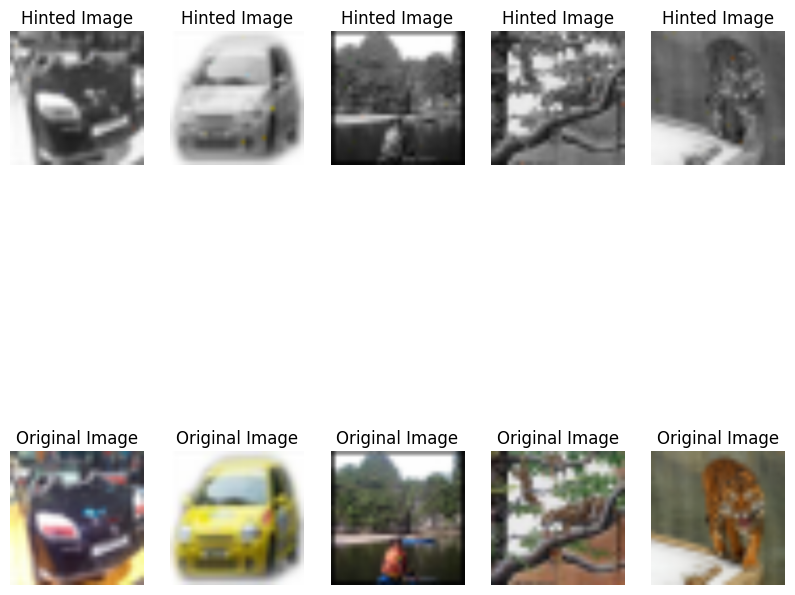

In [26]:
display_hinted_and_original_images(train_loader, num_batches=1, num_images_per_batch=5)

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output 3 channels
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
model = AutoEncoder().to(device)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [31]:
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs, device):
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for hinted_imgs, target_imgs in train_loader:
            hinted_imgs, target_imgs = hinted_imgs.to(device), target_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(hinted_imgs)
            loss = criterion(outputs, target_imgs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for hinted_imgs, target_imgs in valid_loader:
                hinted_imgs, target_imgs = hinted_imgs.to(device), target_imgs.to(device)
                outputs = model(hinted_imgs)
                loss = criterion(outputs, target_imgs)
                running_loss += loss.item()
        epoch_valid_loss = running_loss / len(valid_loader)  # Calculate average loss for the epoch
        valid_losses.append(epoch_valid_loss)

        scheduler.step(epoch_valid_loss)  # Ensure only the epoch's average loss is passed

        print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}')

    return train_losses, valid_losses

In [32]:
def evaluate_on_test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for hinted_imgs, target_imgs in test_loader:
            hinted_imgs, target_imgs = hinted_imgs.to(device), target_imgs.to(device)
            outputs = model(hinted_imgs)
            loss = criterion(outputs, target_imgs)
            running_loss += loss.item()
    test_loss = running_loss / len(test_loader)  # Calculate the average loss over all test batches
    print(f'Test Loss: {test_loss:.4f}')
    return test_loss

In [33]:
train_losses, valid_losses = train_and_validate(
    model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs=10, device=device
)

Epoch 1: Train Loss: 0.0069, Valid Loss: 0.0045
Epoch 2: Train Loss: 0.0049, Valid Loss: 0.0039
Epoch 3: Train Loss: 0.0046, Valid Loss: 0.0038
Epoch 4: Train Loss: 0.0044, Valid Loss: 0.0038
Epoch 5: Train Loss: 0.0043, Valid Loss: 0.0036
Epoch 6: Train Loss: 0.0042, Valid Loss: 0.0036
Epoch 7: Train Loss: 0.0041, Valid Loss: 0.0036
Epoch 8: Train Loss: 0.0040, Valid Loss: 0.0036
Epoch 9: Train Loss: 0.0039, Valid Loss: 0.0042
Epoch 10: Train Loss: 0.0038, Valid Loss: 0.0037


In [34]:
test_loss = evaluate_on_test(model, test_loader, criterion, device)

Test Loss: 0.0037


In [35]:
def plot_loss_curves(train_losses, valid_losses):
    """
    Plot training and validation loss curves.

    Args:
        train_losses (list of float): List of training loss values per epoch.
        valid_losses (list of float): List of validation loss values per epoch.
    """
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(train_losses, label='Training Loss', color='blue')  # Plot training losses
    plt.plot(valid_losses, label='Validation Loss', color='red')  # Plot validation losses
    plt.title('Training and Validation Losses')  # Title of the plot
    plt.xlabel('Epochs')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.legend()  # Add a legend to distinguish the lines
    plt.grid(True)  # Add grid for better readability
    plt.show()  # Display the plot

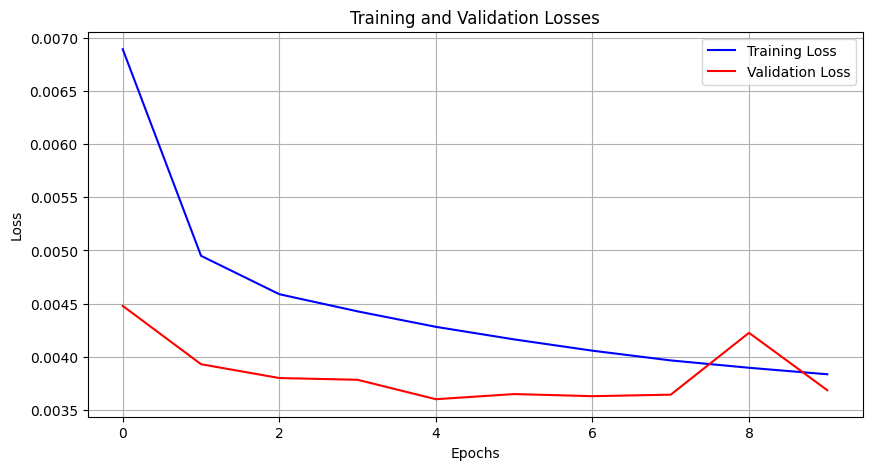

In [36]:
plot_loss_curves(train_losses, valid_losses)

In [47]:
def show_generated_images(model, dataloader, device, num_images=5):
    model.eval()  # Ensure the model is in evaluation mode
    images_so_far = 0
    plt.figure(figsize=(15, 5))

    with torch.no_grad():  # No need to track gradients
        for i, (hinted_imgs, original_imgs) in enumerate(dataloader):
            hinted_imgs = hinted_imgs.to(device)
            original_imgs = original_imgs.to(device)
            outputs = model(hinted_imgs)  # Generate images

            # Move images to CPU and convert to numpy for visualization
            hinted_imgs = hinted_imgs.cpu()
            original_imgs = original_imgs.cpu()
            outputs = outputs.cpu()

            for j in range(hinted_imgs.size(0)):  # Iterate over the batch
                if images_so_far >= num_images:
                    break

                # Display Hinted Image
                ax = plt.subplot(3, num_images, images_so_far + 1)
                plt.imshow(hinted_imgs[j].permute(1, 2, 0))
                ax.axis('off')
                ax.set_title('Hinted Image')

                # Display Original Image
                ax = plt.subplot(3, num_images, images_so_far + 1 + num_images)
                plt.imshow(original_imgs[j].permute(1, 2, 0))
                ax.axis('off')
                ax.set_title('Original Image')

                # Display Generated Image
                ax = plt.subplot(3, num_images, images_so_far + 1 + num_images * 2)
                plt.imshow(outputs[j].permute(1, 2, 0))
                ax.axis('off')
                ax.set_title('Generated Image')

                images_so_far += 1

            if images_so_far >= num_images:
                break

    plt.show()

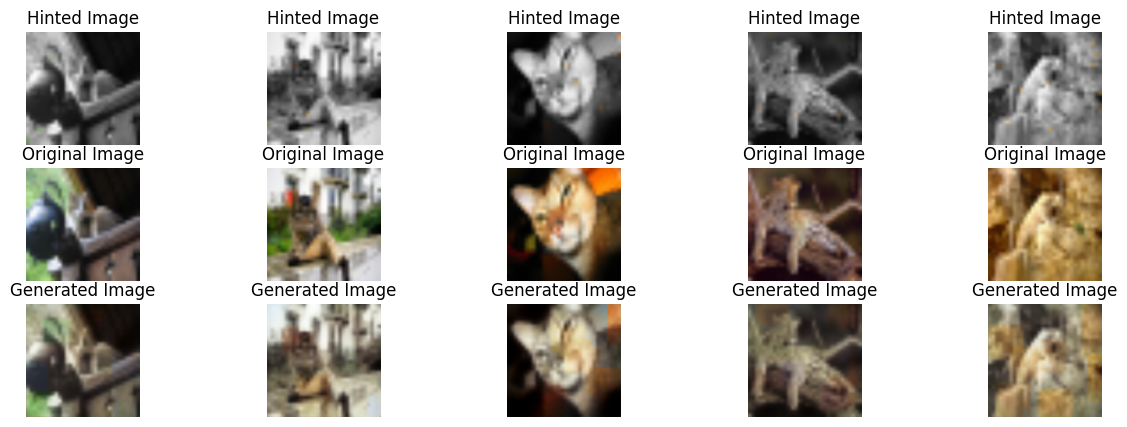

In [48]:
show_generated_images(model, test_loader, device, num_images=5)

In [70]:
data_iter = iter(train_loader)
hinted, color = next(data_iter)

model.eval()
hinted = hinted.to(device)

torch.onnx.export(model, hinted, "model.onnx", opset_version=11, input_names=['input'], output_names=['output'])